# 🕺  It's a high time to try ML for TS.
So, where are we? Let me revise you a bit:
- We have understood the concept of **holt** models and so the EWMA
- Then got hands on the **ARIMA** and seen the seasonal function of it
- ARIMA can be **pretty intrepretable** as well
- Then seen the **auto-ARIMA** and the grid search
- We saw how ML models fail in **extrapolation** badly
- Now, it is the time to see them **working in action** with the real data.

### TL;DR
The ML models ***can*** be used for the time-series if used properly. Now, what is "properly"?

Simply, they fail when used in the **non-differenced** data *(as we will see)* but, if you use them in the **differenced** data then they **work!**. And that's the agenda of this book. So, let's see how.

*(Before making this book, I have already made a long book on this but as said, "long" it felt me so boring. So I deleted it. In here, I want to make is small and compact; instead of trying all models in all situations.)*

In [1]:
# usual imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)

# to see the performance
from sklearn.metrics import r2_score

# ML models to try
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor

# we will use it to convert the non-mtr supported models into supportable
from sklearn.multioutput import MultiOutputRegressor

# in the later examples, we will see warnings for .iloc[] assignment
import warnings
warnings.filterwarnings("ignore")

In [2]:
# loading the data
df = pd.read_csv("../data/airline_passengers.csv", index_col=0, parse_dates=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## 1️⃣  ML Performance without differencing

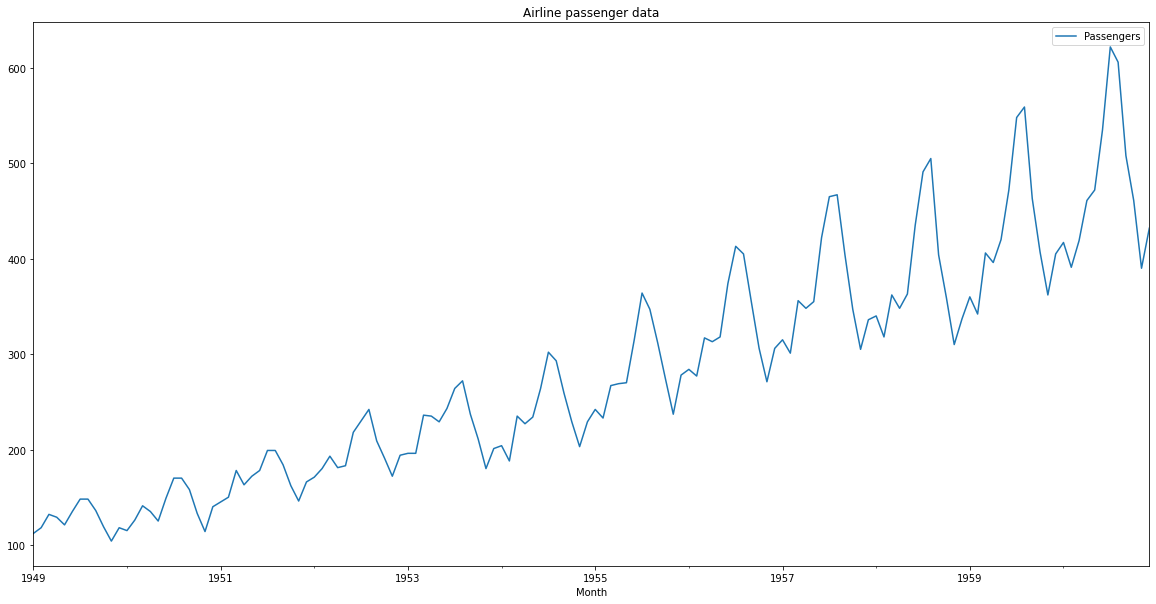

In [3]:
# data
df.plot()
plt.title("Airline passenger data");

In [4]:
# numpy conversion for easy indexing
data = df.Passengers.values

# storing the train and test index for plotting
train_idx = df.iloc[:-12].index
test_idx = df.iloc[-12:].index

We can **predict** the values in 3 ways:
1. One step forecast
2. Multi step forecast
3. Multi output forecast (MTR 😉)

From which we know the OneStep and MultiStep. 
1. **One Step**: Here, we only predict the next single point.
2. **Multi Step**: Take the prediction of previous as an input of this model *(as done in AR(p) example)*
3. **Multi Output**: Train multiple models for multiple points and predict at once. *(This is exactly the MTR that I am researching now-a-days)*

In [5]:
# data transformation into a supervised learning
lag = 10 # taking past 10 data 
X = []
y = []

for offset in range(0, len(data) - lag):
    X.append(data[offset : offset + lag])
    y.append(data[offset + lag])

X = np.array(X)
y = np.array(y)

In [6]:
# data splitting
Xtrain = X[:-12]
ytrain = y[:-12]
Xtest = X[-12:]
ytest = y[-12:]

### `1.` One step

In [7]:
lr = LinearRegression().fit(Xtrain, ytrain)

# this is for the one step only. Don't use Xtest as it involves
# the real world test data and usually results in high accuracy
lr_pred_test = lr.predict(Xtest)
lr_pred_train = lr.predict(Xtrain)

In [8]:
# testing prediction
lr.score(Xtest, ytest)

0.7209726942717989

In [9]:
# training prediction
lr.score(Xtrain, ytrain)

0.9522892096975738

We can see there is `0.72` R2 score. Which is pretty good compared to what we are gonna see in the *multi-step* format.

In [10]:
df.loc[train_idx[lag:], "Train Forecast"] = lr_pred_train
df.loc[test_idx, "Test Forecast (1Step)"] = lr_pred_test

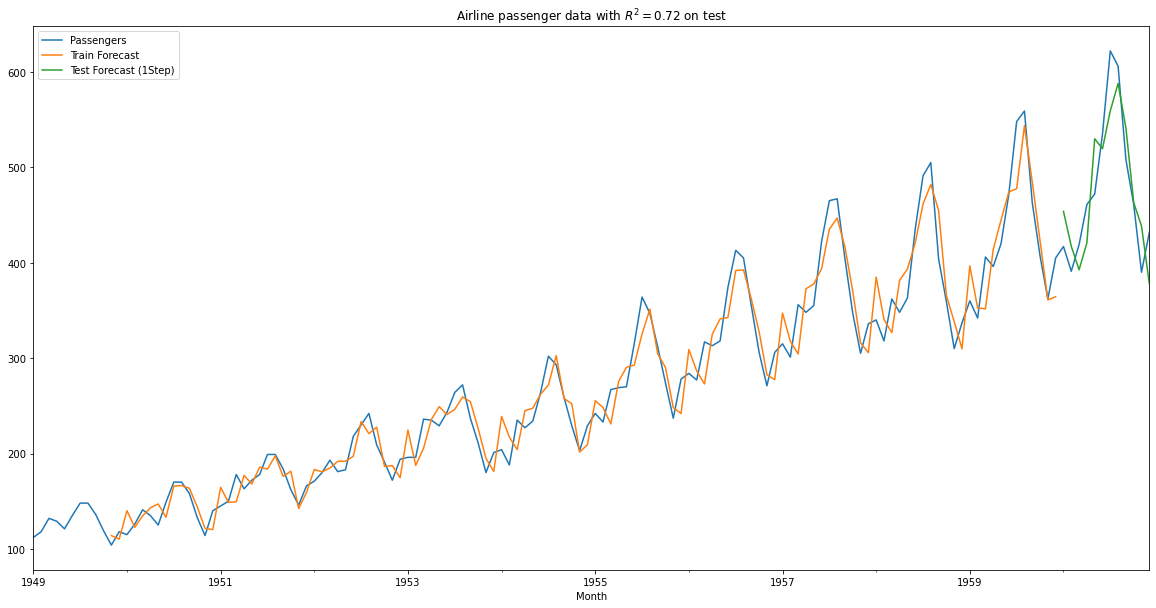

In [11]:
df.plot()
plt.title(f"Airline passenger data with $R^2 = {round(r2_score(ytest, lr_pred_test), 2)}$ on test");

### `2.` Multi Step

In [12]:
lr = LinearRegression().fit(Xtrain, ytrain)

In [13]:
# as we know, for multistep we will need to predict and reuse that prediction

# saving the last X as in the updatable form
last_X = Xtest[0]
multi_step_preds = []
for _ in range(12): # as we will make 12 predictions
    prediction = lr.predict(last_X.reshape(1, -1))[0]
    multi_step_preds.append(prediction)
    last_X = np.roll(last_X, -1)
    last_X[-1] = prediction

In [14]:
df.loc[test_idx, "Test Forecast (MultiStep)"] = multi_step_preds

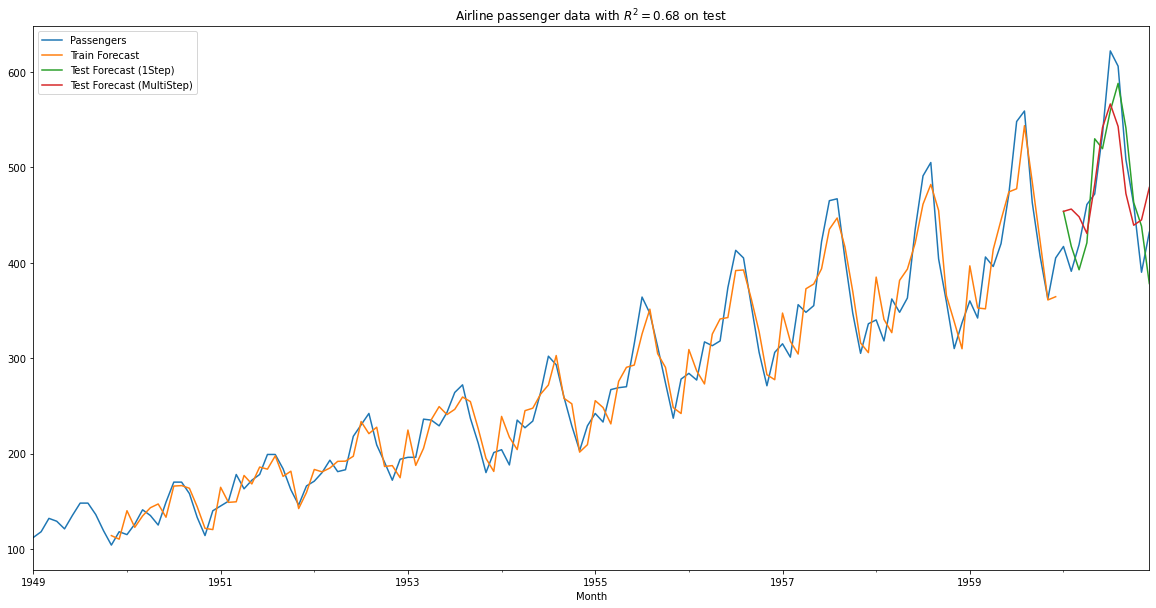

In [15]:
df.plot()
plt.title(f"Airline passenger data with $R^2 = {round(r2_score(ytest, multi_step_preds), 2)}$ on test");

It looks better fit on the test data *(red line)* but the R2 score suggests that it is not. The One-Step performed better as it should be.

### `3.` Multi Output

In [16]:
# for this we will have to construct another dataset
# the current supervised dataset won't help.

lag = 10
h = 12
X, y = [], []
for offset in range(len(data) - lag - h + 1):
    X.append(data[offset : offset+lag])
    y.append(data[offset+lag : offset+lag+h])
    
X = np.array(X)
y = np.array(y)

In [17]:
X.shape

(123, 10)

In [18]:
y.shape

(123, 12)

See? Something is changed. Here we will traing the `y` as in the vector. It is not hard. It is just taking `h` ys and to make it predictable together.

In [19]:
Xtrain_m = X[:-1]
ytrain_m = y[:-1]
Xtest_m = X[-1]
ytest_m = y[-1]

You are getting the indices above, right 🤔 <br>
They are pretty straight-forward.

In [20]:
lr = LinearRegression().fit(Xtrain_m, ytrain_m)

In [21]:
mtr_pred = lr.predict(Xtest_m.reshape(1, -1))

In [22]:
r2_score(ytest_m, mtr_pred.flatten())

0.8810151391474773

This is the highest. Really.

In [23]:
df.loc[test_idx, "Test Forecast (MTR)"] = mtr_pred.flatten()

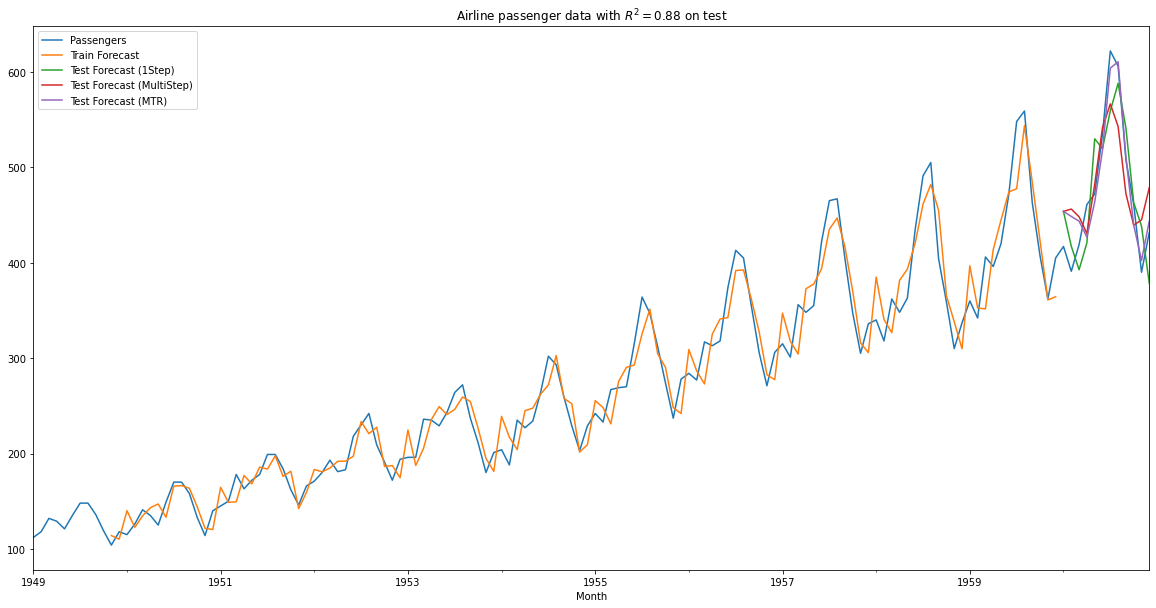

In [24]:
df.plot()
plt.title(f"Airline passenger data with $R^2 = {round(r2_score(ytest_m, mtr_pred.flatten()), 2)}$ on test");

Don't know if you can see the **purple** line or not... but according to the R2, it is the best test accuracy so far.

> You know what? I actually want to stop my self here... but I am willing to make a class to test all models. Let's see how that goes. Sorry, the promise that I made earlier in this book to *"make this book compact"* will no longer applicable.

In [25]:
from copy import copy

In [26]:
class Train_Predict_Plot_Evaluate:
    """
    This class does everything.
    Use with care.
    
    __init__ args:
    
    1. data: Whole data
    2. index: Dataframe index to build a plottable df
    3. Model: The model
    
    It will transform the data into different types
    of supervised problems automatically.
    
    Then the rest is the history. I catually want to
    write more in this doc, but see the execution below
    so you no longer need to read this boring text.
    """
    
    def __init__(self, data, index, model):
        # no need to perform type checks as this is not
        # a library. Only for the internal use
        self.model = model
        self.data = data
        self.plottable = pd.DataFrame(data.reshape(-1, 1), index=index, columns=["Passangers"])
        
        # make supervised for one_step/multi_step
        self.Xtrain, self.Xtest, self.ytrain, self.ytest = \
            self.transform_to_sup_1(data, lag=10, h=12)
        
        # make supervised for multi_output (MTR)
        self.Xtrain_m, self.Xtest_m, self.ytrain_m, self.ytest_m = \
            self.transform_to_sup_2(data, lag=10, h=12)
        
        
    def transform_to_sup_1(self, data, lag, h):
        X, y = [], []
        for offset in range(0, len(data) - lag):
            X.append(data[offset : offset + lag])
            y.append(data[offset + lag]) 
        X = np.array(X)
        y = np.array(y)

        Xtrain = X[:-h]
        ytrain = y[:-h]
        Xtest = X[-h:]
        ytest = y[-h:]    
        return Xtrain, Xtest, ytrain, ytest
    
    
    def transform_to_sup_2(self, data, lag, h):
        X, y = [], []
        for offset in range(len(data) - lag - h + 1):
            X.append(data[offset : offset+lag])
            y.append(data[offset+lag : offset+lag+h])
        X = np.array(X)
        y = np.array(y)
        
        Xtrain_m = X[:-1]
        ytrain_m = y[:-1]
        Xtest_m = X[-1]
        ytest_m = y[-1]
        return Xtrain_m, Xtest_m, ytrain_m, ytest_m
    
    def fit(self):
        self.model1 = copy(self.model) # for one_step and multi_step
        self.model2 = copy(self.model) # for multi_output
        
        # training both models
        self.model1.fit(self.Xtrain, self.ytrain)
        
        # if incase model natively doesn't support MTR
        try:
            self.model2.fit(self.Xtrain_m, self.ytrain_m)
        except:
            self.model2 = MultiOutputRegressor(self.model2)
            self.model2.fit(self.Xtrain_m, self.ytrain_m)
            
        return "Training done!"
    
    def predict(self, model_name):
        # for 1-step
        one_step_preds = self.model1.predict(self.Xtest)
        
        # for multi-step
        last_X = self.Xtest[0]
        multi_step_preds = []
        for _ in range(12): # as we will make 12 predictions
            prediction = self.model1.predict(last_X.reshape(1, -1))[0]
            multi_step_preds.append(prediction)
            last_X = np.roll(last_X, -1)
            last_X[-1] = prediction
            
        # for multi-output
        multi_output_preds = self.model2.predict(self.Xtest_m.reshape(1, -1))
        
        
        # storing
        self.plottable.loc[self.plottable.index[-12:], "One Step"] = one_step_preds
        self.plottable.loc[self.plottable.index[-12:], "Multi Step"] = multi_step_preds
        self.plottable.loc[self.plottable.index[-12:], "Multi Output"] = multi_output_preds.flatten()
        
        # score
        onestep_r2 = round(r2_score(self.ytest, one_step_preds), 2)
        multistep_r2 = round(r2_score(self.ytest, multi_step_preds), 2)
        multioutput_r2 = round(r2_score(self.ytest, multi_output_preds.flatten()), 2)
        
        # plotting
        self.plottable.plot()
        plt.figtext(0.5, 0.885, 
                    model_name, 
                    fontsize=15, ha="center")
        plt.figtext(0.5, 0.86, 
                    f"Onestep: {onestep_r2}  |  MultiStep: {multistep_r2}  |  MultiOutput: {multioutput_r2}",
                    fontsize=12, ha="center")
        plt.subplots_adjust(top=0.85);

Alrighty! Looks cool till now. Let's shoot!

### `1.` Linear Regression

In [27]:
obj = Train_Predict_Plot_Evaluate(data, df.index, LinearRegression())
obj.fit()

'Training done!'

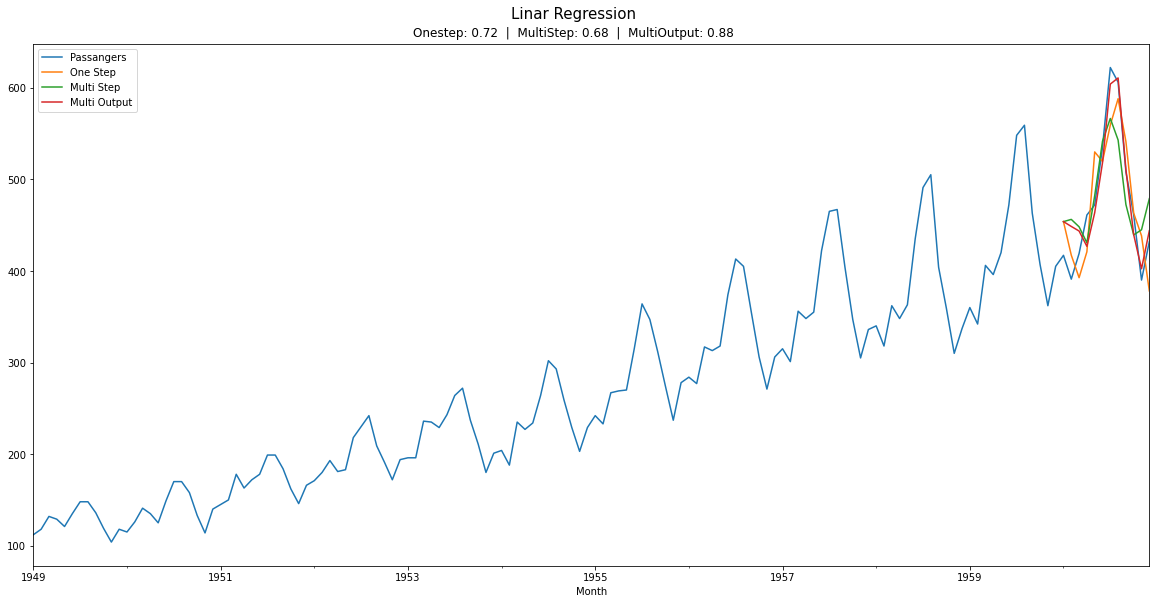

In [28]:
obj.predict("Linar Regression")

Amazing, these are the same results which we have already seen.

### `2.` Random Forest

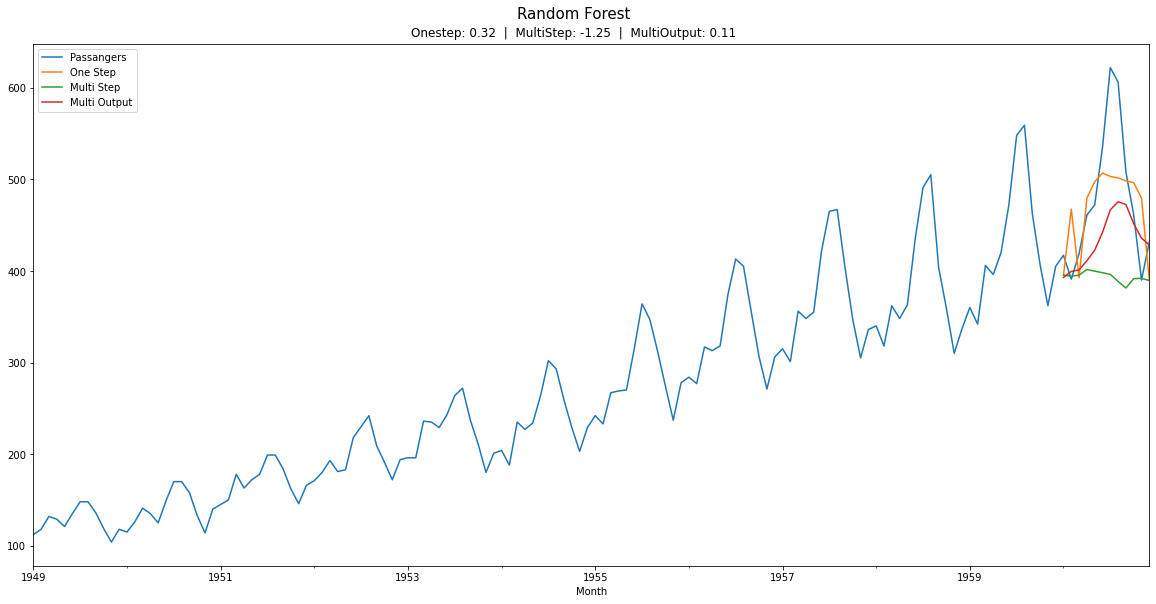

In [29]:
obj = Train_Predict_Plot_Evaluate(data, df.index, RandomForestRegressor())
obj.fit()
obj.predict("Random Forest")

It has poor results. Still the one-step performs better than the rest. <br>
Of course, with some tweaking we *may* get the better results... but I don't think that also can increase the chances.

### `3.` Support Vector Machine

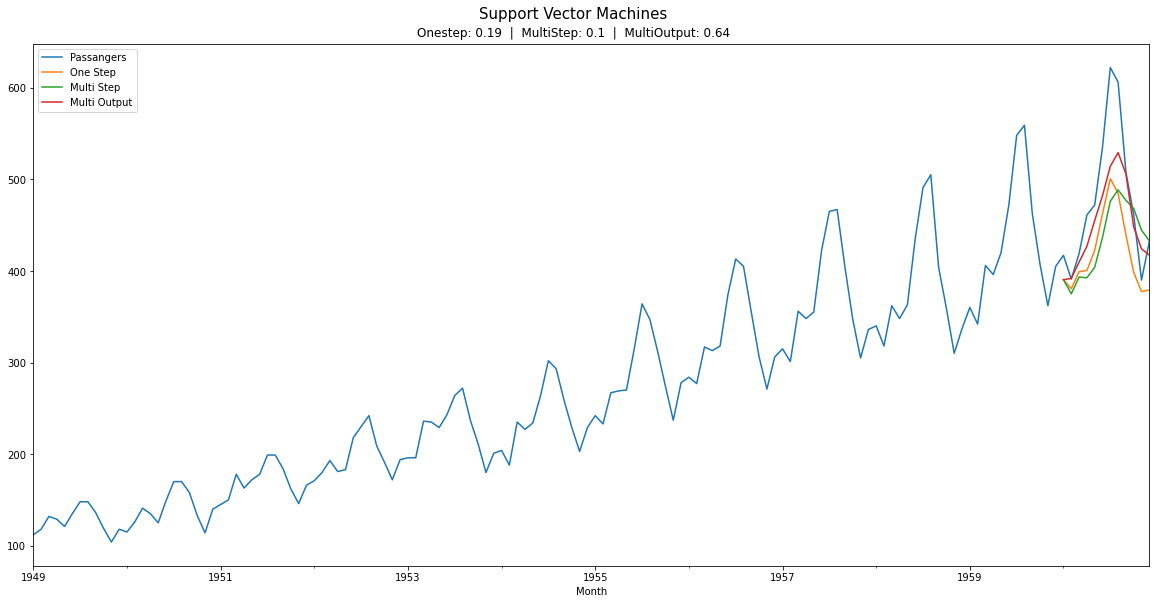

In [30]:
obj = Train_Predict_Plot_Evaluate(data, df.index, SVR(C=100))
obj.fit()
obj.predict("Support Vector Machines")

As we know, the SVR doesn't ***support*** multi-target regression. We can't use it here. We might want to make it usable by `MultiOutputRegression` class.

So, our class has made that usinf the `MOR` and the results are here. 
> NOTE: I have done some setting of `C` hyperparameter in the SVR otherwise the results were ***scary***.

### `4.` KNN

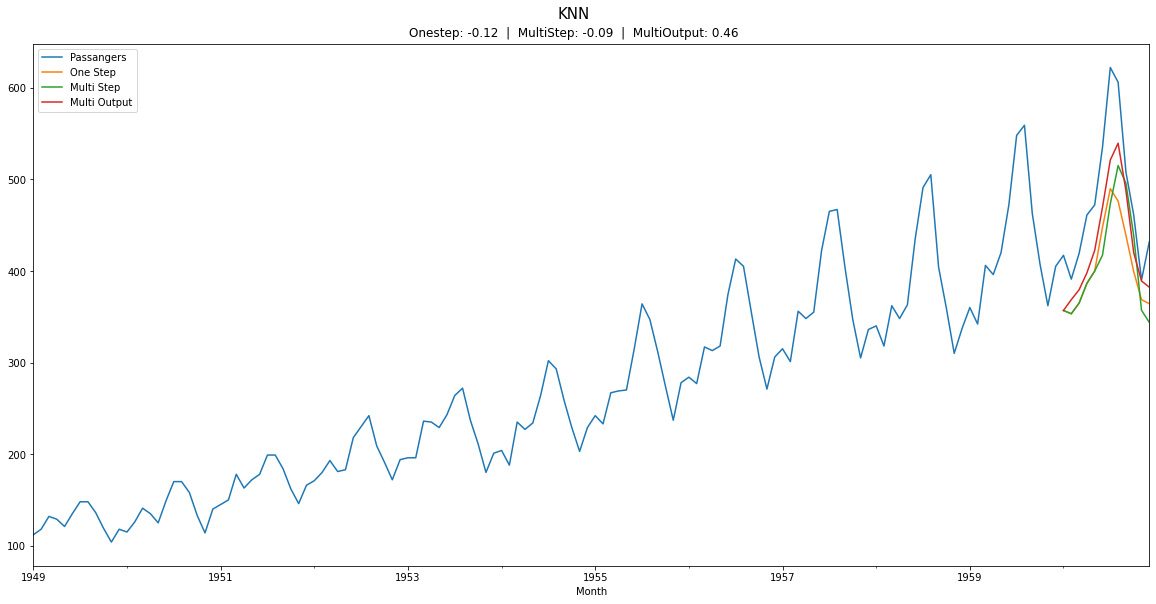

In [31]:
obj = Train_Predict_Plot_Evaluate(data, df.index, KNeighborsRegressor())
obj.fit()
obj.predict("KNN")

Oh! MultiOutput does a better job here. But still not the satisfactory.

### `5.` Neural Network

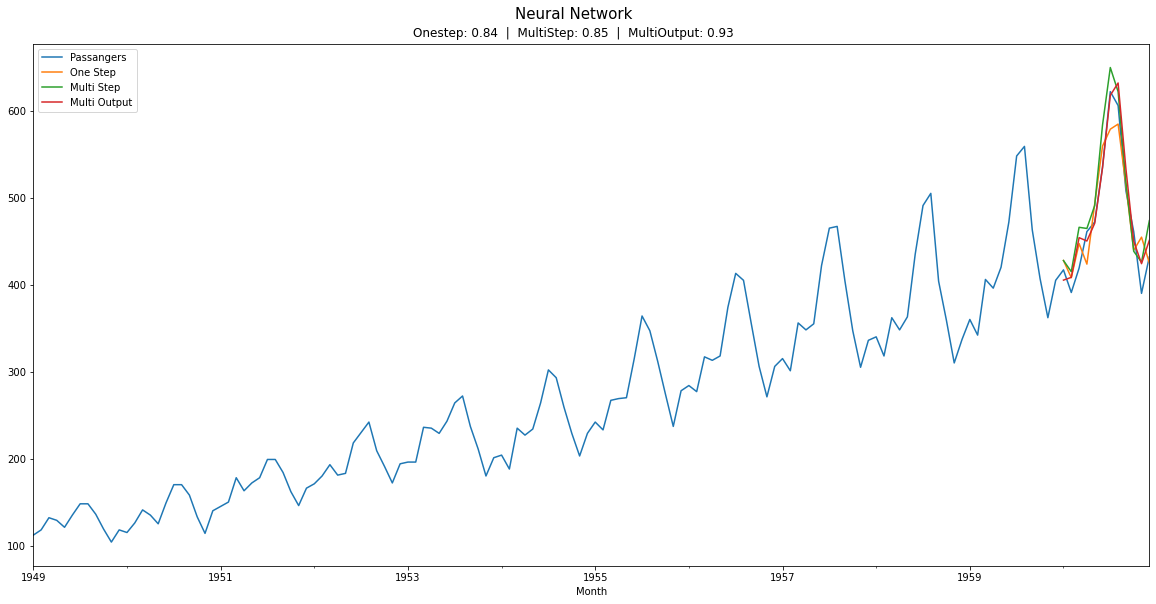

In [32]:
obj = Train_Predict_Plot_Evaluate(data, df.index, MLPRegressor(max_iter=5000, random_state=42))
obj.fit()
obj.predict("Neural Network")

**BEST** of all. Of course some parameters were tuned... but still it is good. Multi output gives the best result.

### `6.` Decision Tree

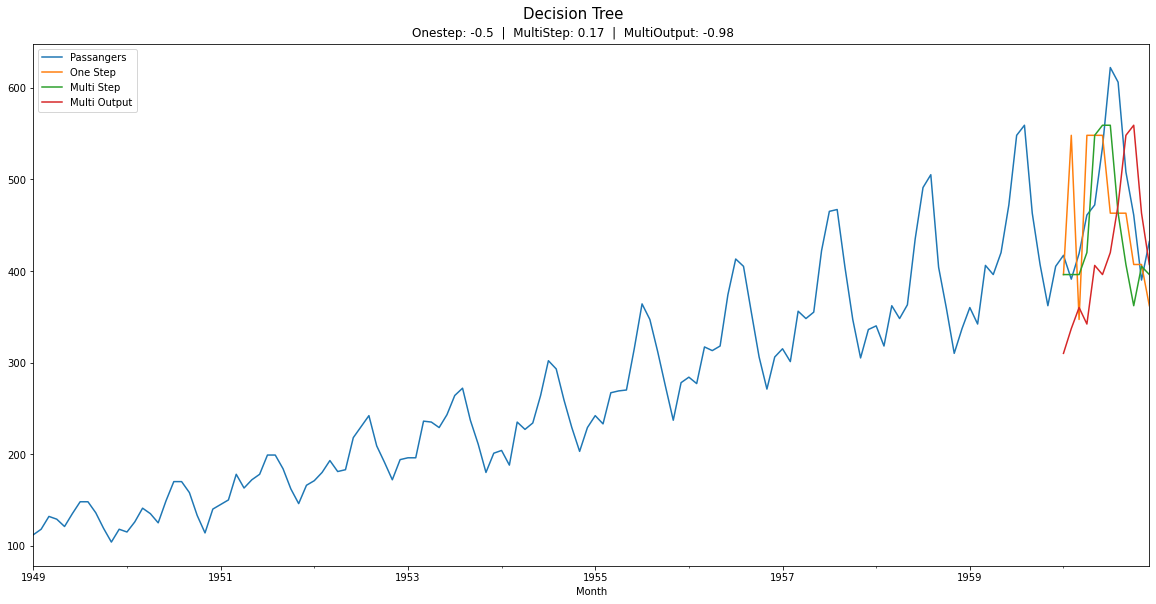

In [33]:
obj = Train_Predict_Plot_Evaluate(data, df.index, DecisionTreeRegressor(random_state=100))
obj.fit()
obj.predict("Decision Tree")

Overfits!

### `7.` Gradient Boost

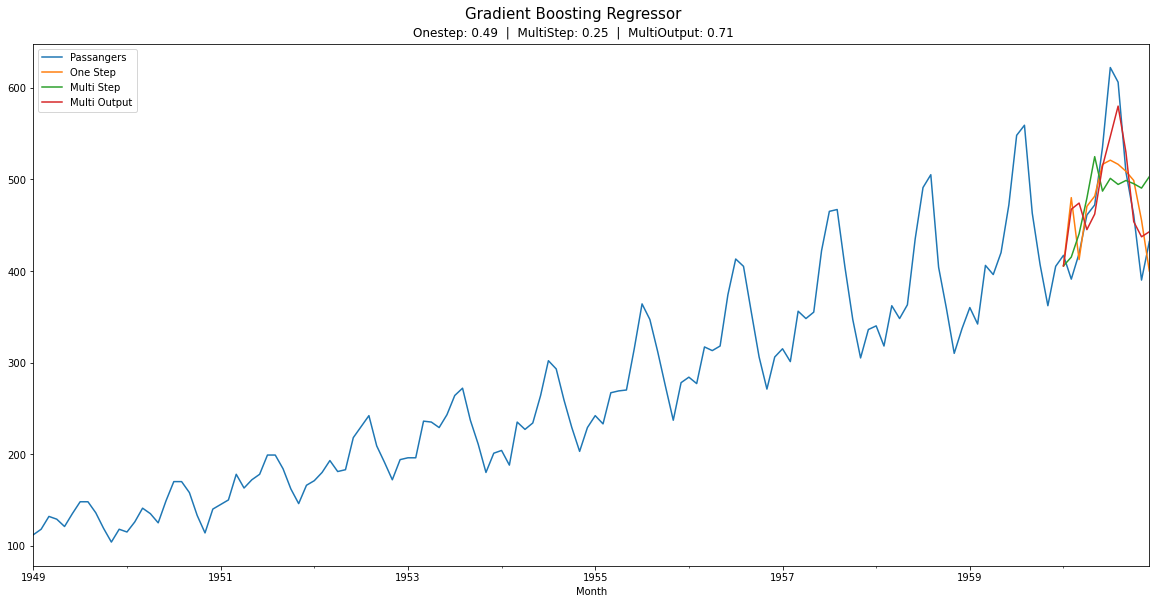

In [34]:
obj = Train_Predict_Plot_Evaluate(data, df.index, GradientBoostingRegressor(random_state=100))
obj.fit()
obj.predict("Gradient Boosting Regressor")

Alrighty!

### Good job!
We have seen multiple models some of which performs poor and others quite good. Except the neural network... I did some tuning but if we still do that for other models we might expect better results. But still, in the next section we will see how the results change when applied **differencing**.

# 

## 2️⃣  ML Performance with differencing

So, here's what happens:
1. We **difference** the time-series.
2. The time-series becomes **stationary**.
3. The **scale changes**.
4. We build the model on ***that*** data *(with different scale)*.
5. We **forecast** and the **result is in the scaled version**.

What now? Did you see the problem? <br>
This is the problem which has to be solved by **re-calculating** the differencing and it is *kind of* an *inverse transform*.

### ⚗ Solution
So, how we take the difference?

## $$\Delta y_t = y_t - y_{t-1}$$

Doing that, we will get a series of...

### $$\text{Differenced} = \Delta y_1, \Delta y_2, \Delta y_3, \cdots, \Delta y_t$$

And, if we do the forecasting...

### $$\text{Forecast} = \Delta \hat y_1, \Delta \hat y_2, \Delta \hat y_3, \cdots, \Delta \hat y_t$$

Just **undo**:

## $$ \hat y_t =y_{t-1} + \Delta \hat y_t $$

That was for the **first** forecast only **where** we will have the last known value $y_{t - 1}$ available.  But after it, to *undo* other sub-sequent forecasts, we will need to use the **predicted & converted** $\hat y_t$ value.

Example:

### $$\text{First value}: \hat y_{t+1} = y_t + \Delta \hat y_{t+1}$$
### $$\text{Second value}: \hat y_{t+2} = \hat y_{t+1} + \Delta \hat y_{t+2}$$
### $$↓$$
### $$\text{Second value}: \hat y_{t+2} = y_t + \Delta \hat y_{t+1} + \Delta \hat y_{t+2}$$

And thus, we have a **pattern**!

### $$\text{Thrid value}: \hat y_{t+3} = y_t + \Delta \hat y_{t+1} + \Delta \hat y_{t+2} + \Delta \hat y_{t+3}$$

###### 

> ### So, it is: "***A cumulative sum of all delta till that $t$ with a sum of last known value $y_t$***".

A *patterned* version of the equation:

### $$\hat y_{t+h} = y_t + \displaystyle \sum_{k=1}^h \Delta \hat y_{t+k}$$

I think, that's pretty straight forward. If still you didn't get it in the first glance; don't worry; keep reading.

### 👨‍💻 Code.

In [35]:
# a fresh start
df = df[["Passengers"]].copy()
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


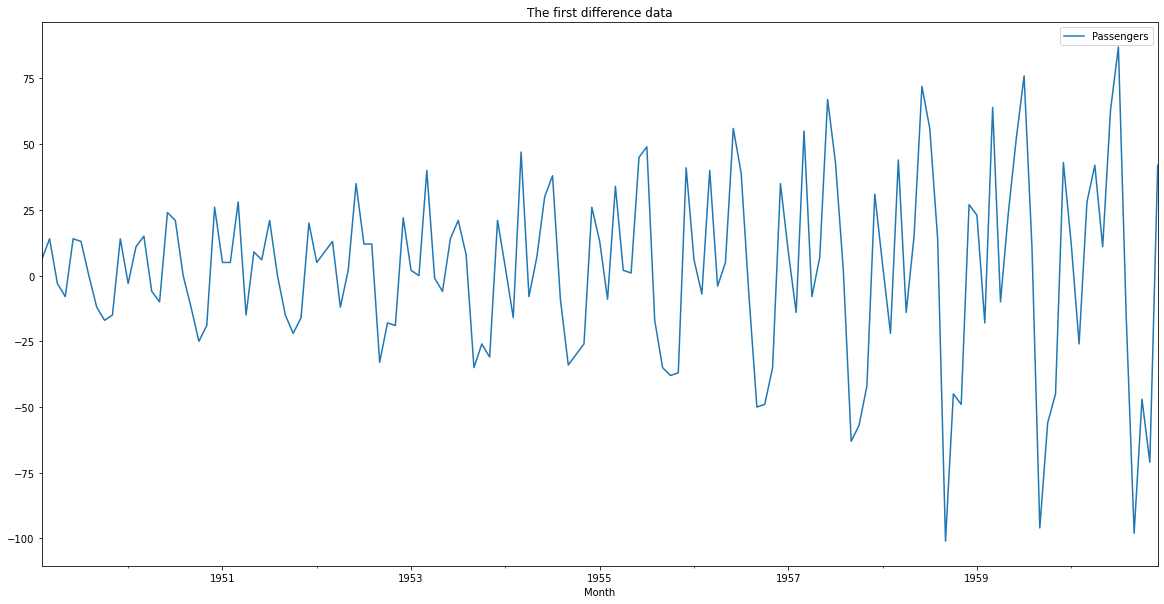

In [36]:
df[["Passengers"]].diff().dropna().plot()
plt.title("The first difference data");

It still looks *non-stationary*... but let's see how that performs in comparision to our *non-differenced* models.

In [37]:
df["Diffed-Passengers"] = df[["Passengers"]].diff()

In [38]:
# because we will take the "real" value to undo difference
df["Shifted-Passengers"] = df["Passengers"].shift(1)

In [39]:
# as we won't be able to use that.
df.iloc[0, [1, 2]] = 0

In [40]:
df.head()

,Passengers,Diffed-Passengers,Shifted-Passengers
Month,,,
1949-01-01,112,0.0,0.0
1949-02-01,118,6.0,112.0
1949-03-01,132,14.0,118.0
1949-04-01,129,-3.0,132.0
1949-05-01,121,-8.0,129.0


In [41]:
data = df["Diffed-Passengers"].values

In [42]:
train_idx = df.iloc[:-12].index
test_idx = df.iloc[-12:].index

In [43]:
# data transformation into a supervised learning
lag = 10 # taking past 10 data 
X = []
y = []
y_real = []
for offset in range(0, len(data) - lag):
    X.append(data[offset : offset + lag])
    y.append(data[offset + lag])

X = np.array(X)
y = np.array(y)

In [44]:
# data splitting
Xtrain = X[:-12]
ytrain = y[:-12]
Xtest = X[-12:]
ytest = y[-12:]

### `1.` One step

In [45]:
lr = LinearRegression().fit(Xtrain, ytrain)
lr_pred_test = lr.predict(Xtest)
lr_pred_train = lr.predict(Xtrain)

In [46]:
# testing prediction
lr.score(Xtest, ytest)

0.6648682628656986

In [47]:
# training prediction
lr.score(Xtrain, ytrain)

0.7954518796768498

We can see there is `0.66` R2 score. Which is pretty bad compared to what we had in the without differencing scenario.

In [48]:
df.loc[train_idx[lag:], "Train Forecast"] = df.loc[train_idx[lag:], "Shifted-Passengers"] + lr_pred_train
df.loc[test_idx, "Test Forecast (1Step)"] = df.loc[test_idx, "Shifted-Passengers"] + lr_pred_test

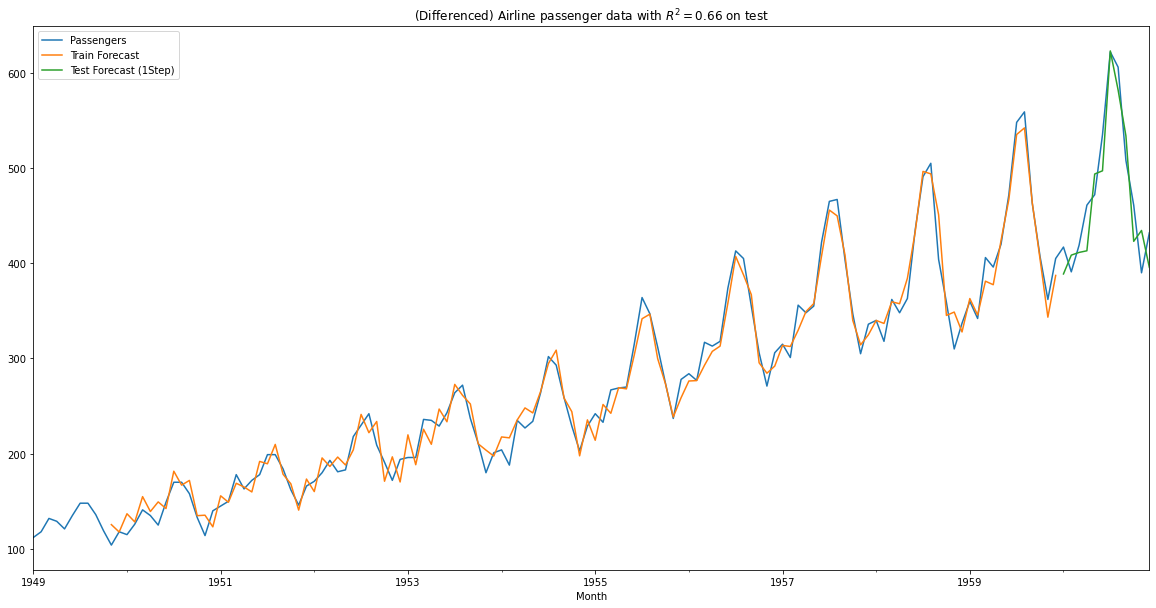

In [49]:
df[["Passengers", "Train Forecast", "Test Forecast (1Step)"]].plot()
plt.title(f"(Differenced) Airline passenger data with $R^2 = {round(r2_score(ytest, lr_pred_test), 2)}$ on test");

Have a look that, the results look **pretty** good! As compared to the One Step done in the **non-differenced** data.

### `2.` Multi Step

In [50]:
lr = LinearRegression().fit(Xtrain, ytrain)

In [51]:
last_X = Xtest[0]
multi_step_preds = []

for _ in range(12): # as we will make 12 predictions
    prediction = lr.predict(last_X.reshape(1, -1))[0]
    multi_step_preds.append(prediction)
    last_X = np.roll(last_X, -1)
    last_X[-1] = prediction

In [52]:
# this is the value which is known and then in the later
# part we will perform the cumsum to get the real data points
last_train = df["Shifted-Passengers"].loc[test_idx[0]]

In [53]:
# this is an amazing line.
# This will add 1 value (last_train) + 12 values (multi_step_preds)
df.loc[test_idx, "Test Forecast (MultiStep)"] = last_train + np.cumsum(multi_step_preds)

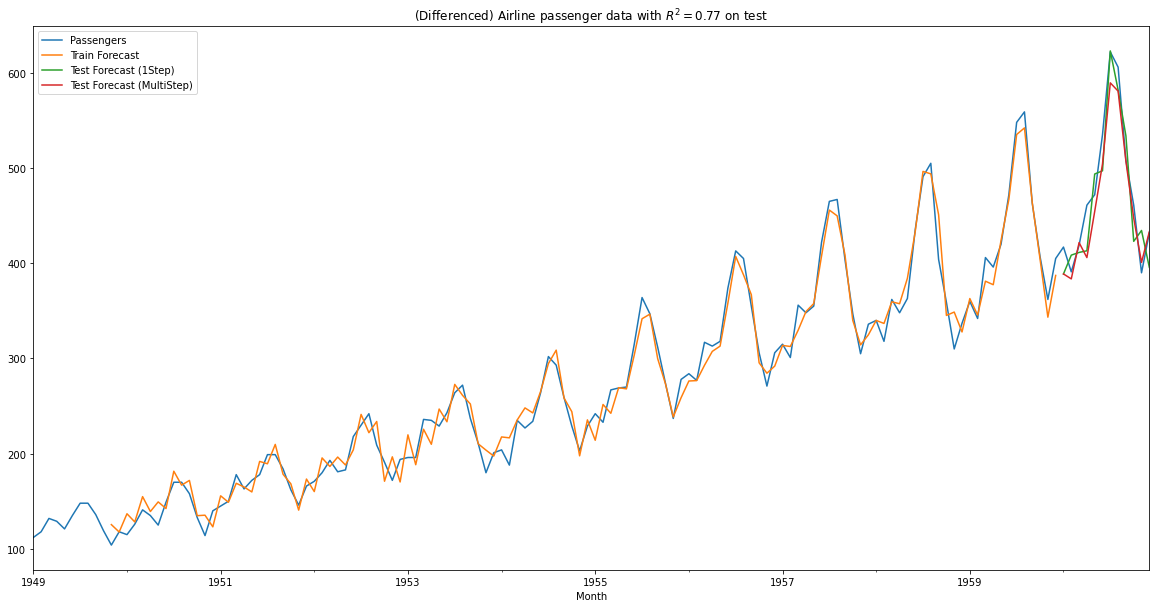

In [54]:
df[["Passengers", "Train Forecast", "Test Forecast (1Step)", "Test Forecast (MultiStep)"]].plot()
plt.title(f"(Differenced) Airline passenger data with $R^2 = {round(r2_score(ytest, multi_step_preds), 2)}$ on test");

See! How the performance has increased buy just taking the difference. *(Compared to the multi step with Linear Regression where we received the `0.68` R2)*.

### `3.` Multi Output

In [55]:
# for this we will have to construct another dataset
# the current supervised dataset won't help.

lag = 10
h = 12
X, y = [], []
for offset in range(len(data) - lag - h + 1):
    X.append(data[offset : offset+lag])
    y.append(data[offset+lag : offset+lag+h])
    
X = np.array(X)
y = np.array(y)

In [56]:
X.shape

(123, 10)

In [57]:
y.shape

(123, 12)

See? Something is changed. Here we will traing the `y` as in the vector. It is not hard. It is just taking `h` ys and to make it predictable together.

In [58]:
Xtrain_m = X[:-1]
ytrain_m = y[:-1]
Xtest_m = X[-1]
ytest_m = y[-1]

In [59]:
lr = LinearRegression().fit(Xtrain_m, ytrain_m)

In [60]:
mtr_pred = lr.predict(Xtest_m.reshape(1, -1))

In [61]:
r2_score(ytest_m, mtr_pred.flatten())

0.7821864112843452

Alright... Alright... better than MultiStep.

In [62]:
# again the same way we will do the undo
df.loc[test_idx, "Test Forecast (MTR)"] = last_train + np.cumsum(mtr_pred.flatten())

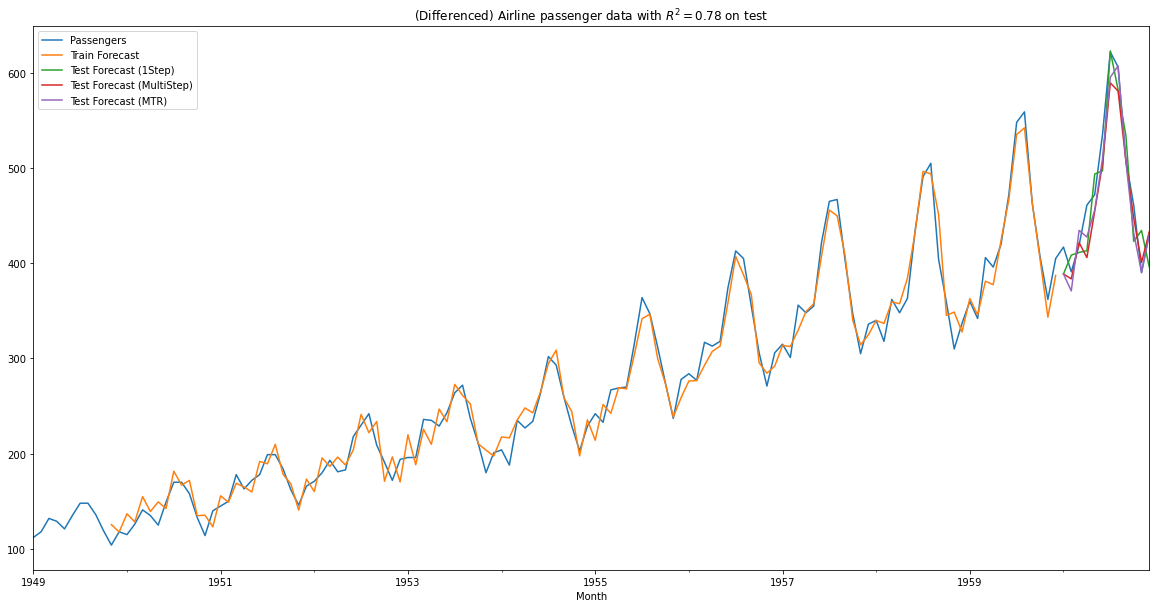

In [63]:
df[["Passengers", "Train Forecast", 
    "Test Forecast (1Step)", 
    "Test Forecast (MultiStep)", 
    "Test Forecast (MTR)"]].plot()
plt.title(f"(Differenced) Airline passenger data with $R^2 = {round(r2_score(ytest, mtr_pred.flatten()), 2)}$ on test");

We are doing great guys. Again, a purple line. Not visible. But still the forecast is the **higest** compared to the rest methods.

##### 

### 🤗  Do you really wanna see another class for this differencing? Haan?
I got you. Let's make it.

> I want this class to be ***clutter free***. Means, we can make use if a `toggle` like `differenced=True` or not. Which will be just a single arguement, but in the class itself, it won't be much readable.  <br> <br> So, making another class for differencing & have put the comments by `### HERE ###` to highlight the change compared to previous class.

In [64]:
class Train_Predict_Plot_Evaluate:
    """
    This class does everything. But with differencing.
    Use with care.
    
    PLEASE PROVIDE THE NON-DIFFERENCED DATA i.e. ORIGINAL
    TO MAKE SENSE OF THE PLOT.
    
    __init__ args:
    
    1. data: Whole data
    2. index: Dataframe index to build a plottable df
    3. Model: The model
    
    It will transform the data into different types
    of supervised problems automatically.
    
    Then the rest is the history. I catually want to
    write more in this doc, but see the execution below
    so you no longer need to read this boring text.
    """
    
    def __init__(self, data, index, model):
        # no need to perform type checks as this is not
        # a library. Only for the internal use
        self.model = model
        self.plottable = pd.DataFrame(data.reshape(-1, 1), index=index, columns=["Passangers"])
        self.plottable["Shifted-Passangers"] = self.plottable["Passangers"].shift(1) ### HERE ###
        self.plottable["Diffed-Passengers"] = self.plottable["Passangers"].diff() ### HERE ###
        self.plottable["Diffed-Passengers"].iloc[0] = 0
        self.data = self.plottable["Diffed-Passengers"].values ### HERE ###
        
        # make supervised for one_step/multi_step
        self.Xtrain, self.Xtest, self.ytrain, self.ytest = \
            self.transform_to_sup_1(self.data, lag=10, h=12)
        
        # make supervised for multi_output (MTR)
        self.Xtrain_m, self.Xtest_m, self.ytrain_m, self.ytest_m = \
            self.transform_to_sup_2(self.data, lag=10, h=12)
        
        
    def transform_to_sup_1(self, data, lag, h):
        X, y = [], []
        for offset in range(0, len(data) - lag):
            X.append(data[offset : offset + lag])
            y.append(data[offset + lag]) 
        X = np.array(X)
        y = np.array(y)

        Xtrain = X[:-h]
        ytrain = y[:-h]
        Xtest = X[-h:]
        ytest = y[-h:]    
        return Xtrain, Xtest, ytrain, ytest
    
    
    def transform_to_sup_2(self, data, lag, h):
        X, y = [], []
        for offset in range(len(data) - lag - h + 1):
            X.append(data[offset : offset+lag])
            y.append(data[offset+lag : offset+lag+h])
        X = np.array(X)
        y = np.array(y)
        
        Xtrain_m = X[:-1]
        ytrain_m = y[:-1]
        Xtest_m = X[-1]
        ytest_m = y[-1]
        return Xtrain_m, Xtest_m, ytrain_m, ytest_m
    
    def fit(self):
        self.model1 = copy(self.model) # for one_step and multi_step
        self.model2 = copy(self.model) # for multi_output
        
        # training both models
        self.model1.fit(self.Xtrain, self.ytrain)
        
        # if incase model natively doesn't support MTR
        try:
            self.model2.fit(self.Xtrain_m, self.ytrain_m)
        except:
            self.model2 = MultiOutputRegressor(self.model2)
            self.model2.fit(self.Xtrain_m, self.ytrain_m)
            
        return "Training done!"
    
    def predict(self, model_name):
        # for 1-step
        one_step_preds = self.model1.predict(self.Xtest)
        
        # for multi-step
        last_X = self.Xtest[0]
        multi_step_preds = []
        for _ in range(12): # as we will make 12 predictions
            prediction = self.model1.predict(last_X.reshape(1, -1))[0]
            multi_step_preds.append(prediction)
            last_X = np.roll(last_X, -1)
            last_X[-1] = prediction
            
        # for multi-output
        multi_output_preds = self.model2.predict(self.Xtest_m.reshape(1, -1))
        
        
        # storing
        last_train = self.plottable["Shifted-Passangers"].iloc[-12] 
        self.plottable.loc[self.plottable.index[-12:], "One Step"] = \
            self.plottable["Shifted-Passangers"].iloc[-12:] + one_step_preds 
        self.plottable.loc[self.plottable.index[-12:], "Multi Step"] = last_train + np.cumsum(multi_step_preds) 
        self.plottable.loc[self.plottable.index[-12:], "Multi Output"] = last_train + np.cumsum(multi_output_preds.flatten()) 
        
        ### THERE ABOVE 4 LINES HAVE "HERE" ###
        
        # score
        onestep_r2 = round(r2_score(self.ytest, one_step_preds), 2)
        multistep_r2 = round(r2_score(self.ytest, multi_step_preds), 2)
        multioutput_r2 = round(r2_score(self.ytest, multi_output_preds.flatten()), 2)
        
        # plotting
        self.plottable[["Passangers", "One Step", "Multi Step", "Multi Output"]].plot()
        plt.figtext(0.5, 0.885, 
                    model_name, 
                    fontsize=15, ha="center")
        plt.figtext(0.5, 0.86, 
                    f"Onestep: {onestep_r2}  |  MultiStep: {multistep_r2}  |  MultiOutput: {multioutput_r2}",
                    fontsize=12, ha="center")
        plt.subplots_adjust(top=0.85);

In [65]:
data = df["Passengers"].values
index = df.index

### `1.` Linear Regression

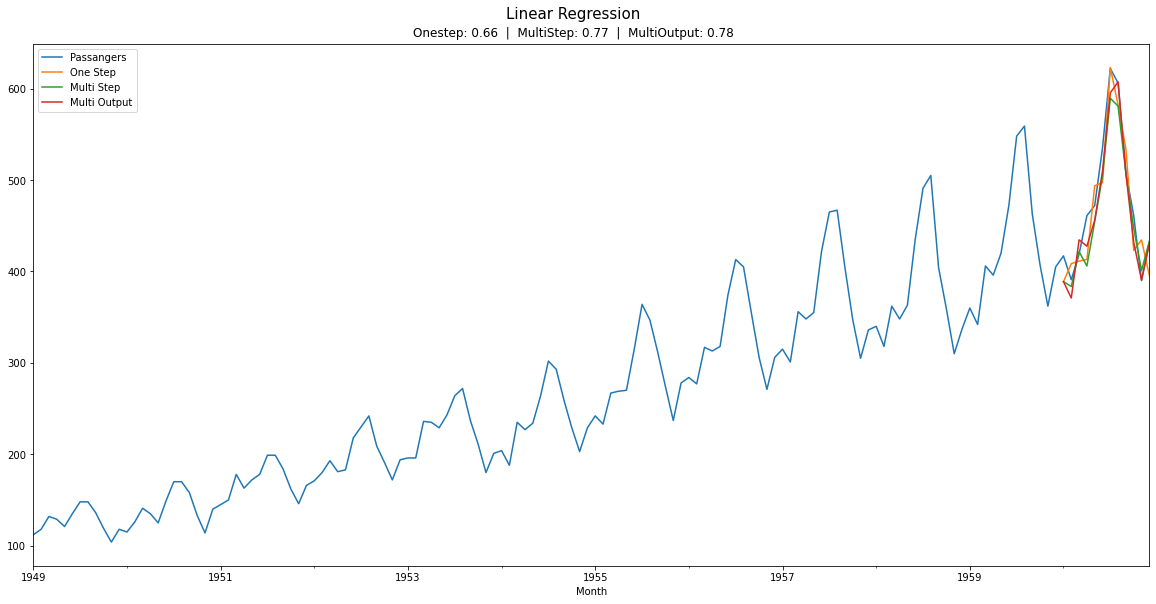

In [66]:
obj = Train_Predict_Plot_Evaluate(data, index, LinearRegression())
obj.fit()
obj.predict("Linear Regression")

Comparision:

|                                     | **Non-Differencing** | **Differencing**  |
|------------------|----------------------|------------------|
| **One-Step**        |                                    0.72|                            0.66|
| **Multi-Step**      |                                    0.68|                            0.77|
| **Multi-Output** |                                    0.88|                            0.78|

### `2.` Random Forest

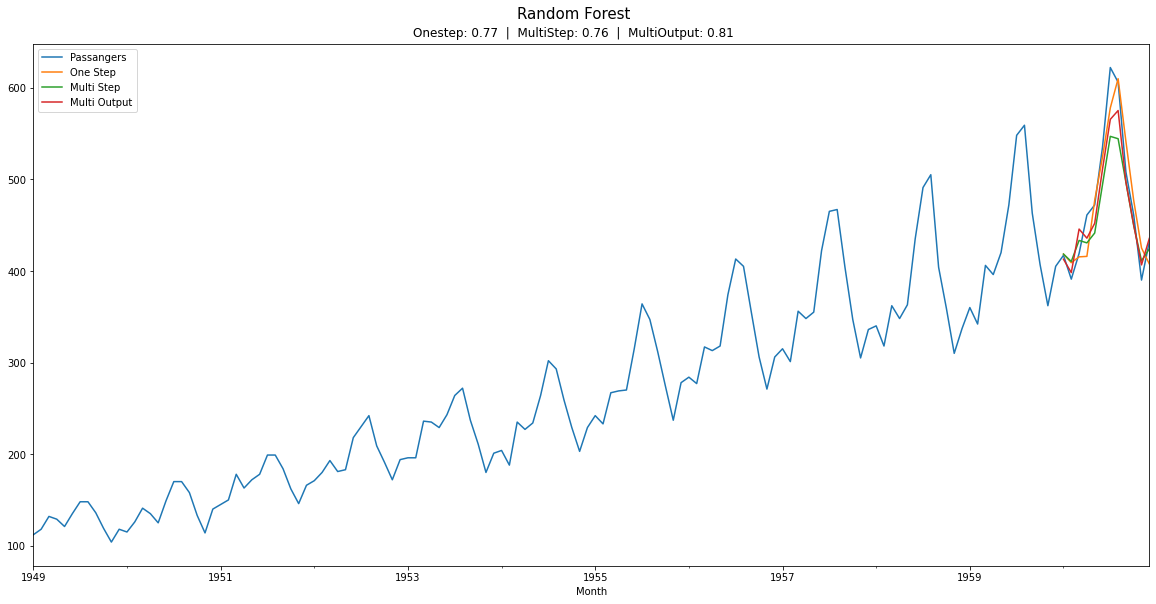

In [67]:
obj = Train_Predict_Plot_Evaluate(data, index, RandomForestRegressor())
obj.fit()
obj.predict("Random Forest")

Comparision:

|                                     | **Non-Differencing** | **Differencing**  |
|------------------|----------------------|------------------|
| **One-Step**        |                                    0.27|                            0.73|
| **Multi-Step**      |                                  -0.35|                            0.74|
| **Multi-Output** |                                     0.15|                            0.82|

### `3.` Support Vector Machine

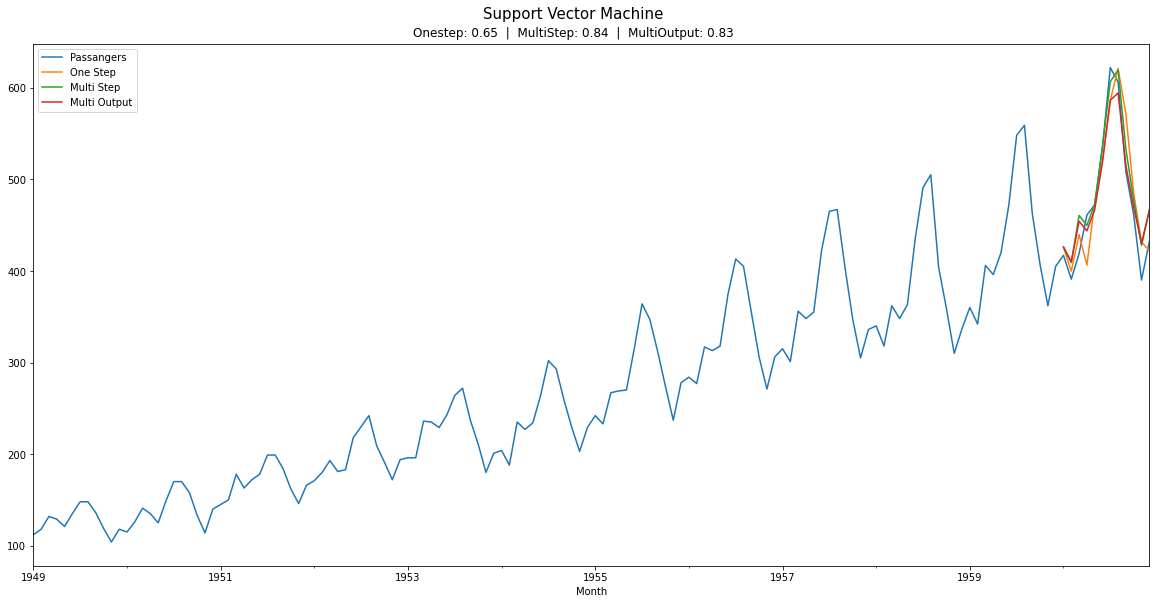

In [68]:
obj = Train_Predict_Plot_Evaluate(data, index, SVR(C=100))
obj.fit()
obj.predict("Support Vector Machine")

Comparision:

|                                     | **Non-Differencing** | **Differencing**  |
|------------------|----------------------|------------------|
| **One-Step**        |                                    0.19|                            0.65|
| **Multi-Step**      |                                  -0.1|                            0.84|
| **Multi-Output** |                                     0.64|                            0.83|

### `4.` KNN

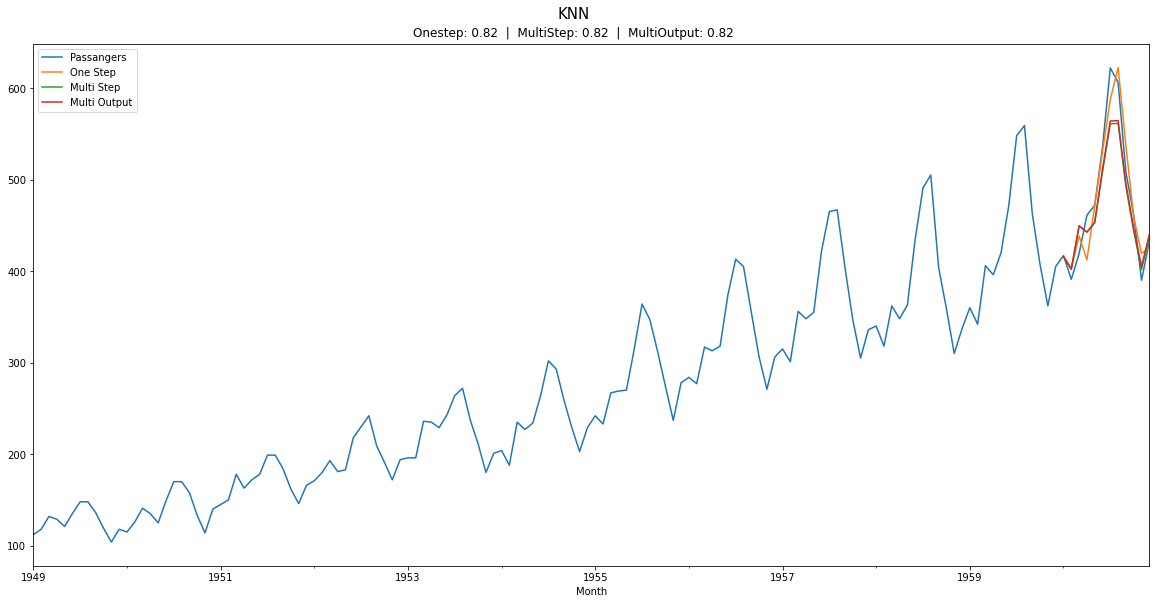

In [69]:
obj = Train_Predict_Plot_Evaluate(data, index, KNeighborsRegressor())
obj.fit()
obj.predict("KNN")

Comparision:

|                                     | **Non-Differencing** | **Differencing**  |
|------------------|----------------------|------------------|
| **One-Step**        |                                    -0.12|                            0.82|
| **Multi-Step**      |                                  -0.9|                            0.82|
| **Multi-Output** |                                     0.46|                            0.82|

### `5.` Neural Network

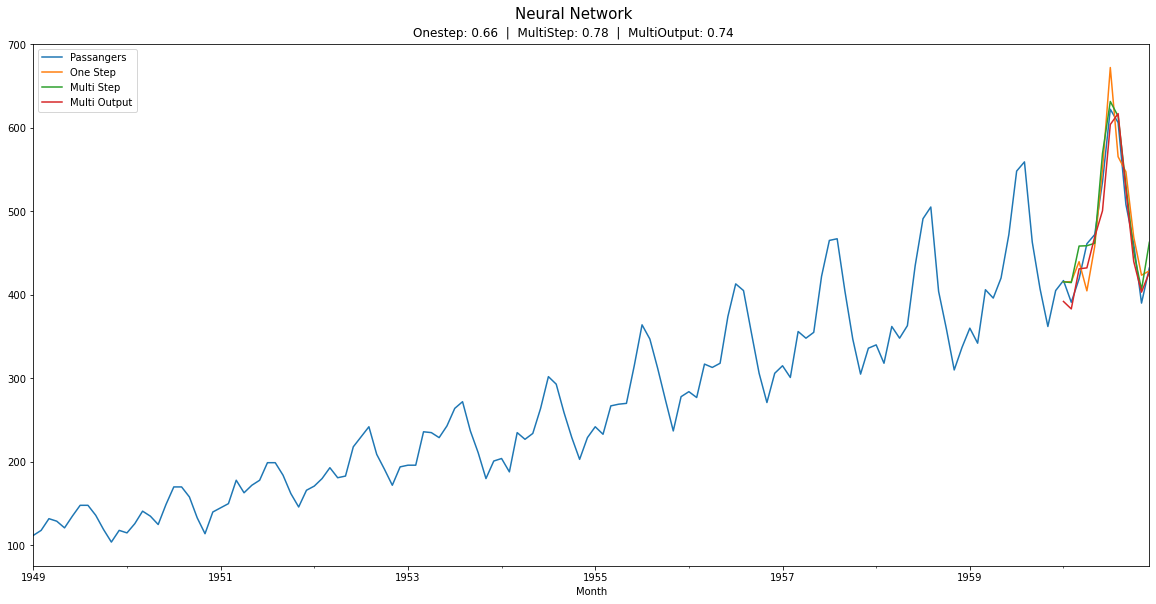

In [70]:
obj = Train_Predict_Plot_Evaluate(data, index, MLPRegressor(max_iter=5000, random_state=42))
obj.fit()
obj.predict("Neural Network")

Comparision:

|                                     | **Non-Differencing** | **Differencing**  |
|------------------|----------------------|------------------|
| **One-Step**        |                                    0.84|                            0.66|
| **Multi-Step**      |                                  0.85|                            0.78|
| **Multi-Output** |                                     0.93|                            0.74|

### `6.` Decision Tree

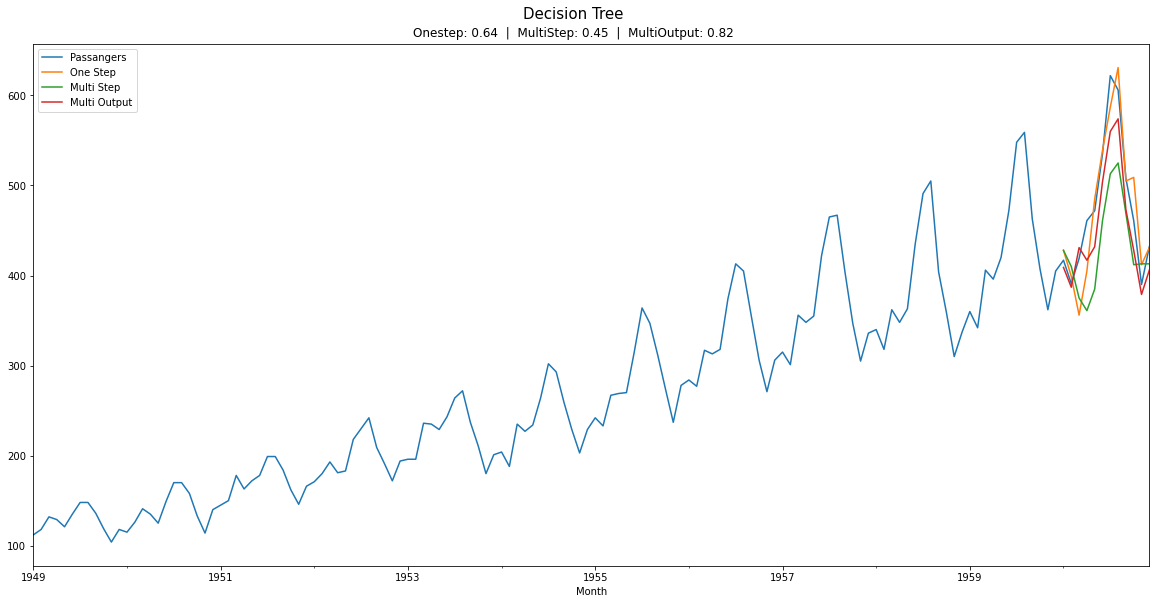

In [71]:
obj = Train_Predict_Plot_Evaluate(data, index, DecisionTreeRegressor(random_state=100))
obj.fit()
obj.predict("Decision Tree")

Comparision:

|                                     | **Non-Differencing** | **Differencing**  |
|------------------|----------------------|------------------|
| **One-Step**        |                                    -0.5|                            0.64|
| **Multi-Step**      |                                  0.17|                            0.45|
| **Multi-Output** |                                     -0.98|                            0.82|

### `7.` Gradient Boosting Regression

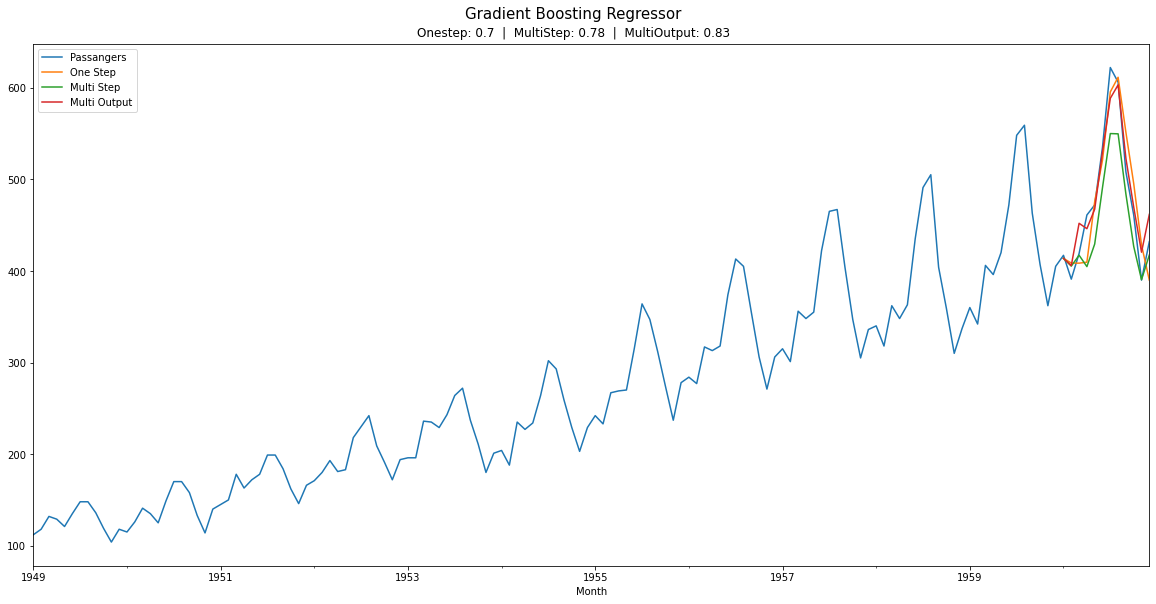

In [72]:
obj = Train_Predict_Plot_Evaluate(data, index, GradientBoostingRegressor(random_state=100))
obj.fit()
obj.predict("Gradient Boosting Regressor")

Comparision:

|                                     | **Non-Differencing** | **Differencing**  |
|------------------|----------------------|------------------|
| **One-Step**        |                                    0.49|                            0.7|
| **Multi-Step**      |                                  0.25|                            0.78|
| **Multi-Output** |                                     0.71|                            0.83|

# 

# Great!
We have seen the improvement in **most** of the models after doing the differencing. How was it! I know, this has bee a **pretty**, **pretty**, **pretty** long book and I broke my rule as well, but tell me whether this was a fun or not!

Let's meet you in the next book.